In [0]:
# !pip install tensorboardcolab

In [2]:
#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# import the necessary Deep learning packages
import tensorflow as tf
import keras
from keras import backend as K
from keras.backend import tensorflow_backend
# import livelossplot


#preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator,load_img

#modelcreation libraries
from keras.models import Sequential,Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation,Flatten,Dropout,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorboardcolab import  TensorBoardColab, TensorBoardColabCallback

#importing pretrained models
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.utils.vis_utils import plot_model


#import data read/write packages
import glob
import os
from tqdm import tqdm
from os import walk

## required for efficient GPU use
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

Using TensorFlow backend.


In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/dilab")

In [0]:
tbc=TensorBoardColab()

In [0]:
img_size = 224
batch_size = 32
epochs = 250
num_classes = 4
model_type = 'messidor_tf'

## Paths for IDRID Dataset

In [0]:
train_path = './B. Disease Grading/1. Original Images/a. Training Set/*.jpg'
test_path = './B. Disease Grading/1. Original Images/b. Testing Set/*jpg'
train_label_path = './B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
test_label_path = './B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'

## Path for Messidor Dataset

In [0]:
messi_data_path = './messidor/data/'

## Function to read Messidor data

In [0]:
def augment():
    
    rot_angles = np.array([-5,5,0,0,0,0])
    data_gen = ImageDataGenerator(
            rotation_range= np.random.choice(rot_angles,size=1)[0],
#             width_shift_range=0.1,
#             height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip= True
            )
    return data_gen

In [0]:
def weighted_sampling(data,labels):
    
    data_per_class = []
    data_dist = plt.hist(labels,bins=num_classes)[0]
    maj_class = np.argmax(data_dist)
    max_size = int(data_dist[maj_class])
    
    print("Majority class is {}\nData Distribution : {}".format(maj_class,data_dist))
    
    for i in range(num_classes):
        
        if(i!=maj_class):
            
            data_per_class = (data[labels==i])
            data_gen = augment()
            data_gen.fit(data_per_class)
            class_size = len(data_per_class)
            
            if(class_size<(max_size-class_size)):
                for k in range(int((max_size-class_size) // class_size)+1):
                    img_gen = data_gen.flow(data_per_class,batch_size=(max_size-class_size))
                    if(k==0):
                      print(next(img_gen).shape)
                      imags = next(img_gen)
                    else:
                      imags = np.vstack((imags,(next(img_gen))))
#                 print(imags.shape)
            else:
                img_gen = data_gen.flow(data_per_class,batch_size=(max_size-class_size))
                imags = next(img_gen)
                
            
            data = np.vstack((data,imags[:(max_size-class_size)]))
#             print(data.shape)
            labels = np.concatenate((labels,np.ones(max_size-class_size)*i))
#             print(labels.shape)
            shuffled_index = np.arange(len(data))
            np.random.shuffle(shuffled_index)
            data = data[shuffled_index]
            labels = labels[shuffled_index]
                
            
    return data,labels

In [0]:
def read_data(data_path=train_path,label_path=train_label_path,dir_path=None,istest=False,dataset='idrid',num_classes=5):
    
    if(dataset=='Kaggle'):
        
        img_files = np.sort(glob.glob(data_path))

        x = np.array([np.array(load_img(img,target_size=(img_size,img_size,3))) 
                            for img in tqdm(img_files)])
        
        img_files_stripped = [img_file.strip(kag_path) for img_file in img_files]
        
        labels = labels[np.isin(label_df.iloc[:,0].values,img_files_stripped)]

        
    elif(dataset=='messidor' and dir_path is not None):
       
        for (sub_dirpath, sub_dirs, filenames) in walk(dir_path):
#             print(sub_dirs)
            break

        k = 0
        for sub_dir in tqdm(sub_dirs):
            
            sub_dir_path = os.path.join(dir_path,sub_dir)
            label_path = glob.glob("{}/*.xls".format(sub_dir_path))[0]
            img_paths =("{}/*.tif".format(sub_dir_path))
            img_files = np.sort(glob.glob(img_paths))
            df = pd.read_excel(label_path)

            if(k==0):
                x = (np.array([np.array(load_img(img,target_size=(img_size,img_size,3))) 
                                for img in (img_files)]))
                labels = df.iloc[:,2].values
                k+=1
            else:
                x = np.vstack((x,(np.array([img_to_array(load_img(img,target_size=(img_size,img_size,3))) 
                                    for img in (img_files)]))))
                labels = np.concatenate((labels,(df.iloc[:,2].values)))
                
    else:
            
        img_files = np.sort(glob.glob(data_path))

        x = np.array([np.array(load_img(img,target_size=(img_size,img_size,3))) 
                            for img in tqdm(img_files)])

        label_df = pd.read_csv(label_path)
        labels = label_df.iloc[:,1].values

    
#     if(istest is False and class_weights is not None):
#            class_weights = class_weight.compute_class_weight('balanced',np.unique(labels),labels)
  #         x,labels = weighted_sampling(x,labels)
  
#   print("Training cum Validation data size: {}".format(x.shape[0]))
#         print("New Distribution :{} \n".format(plt.hist(labels,bins=num_classes)[0]))
        
#     print(label_df.head())
    y= to_categorical(labels, num_classes=num_classes)

    return x,y,labels

In [0]:
def split_data(data,labels,ratio=0.2):
    return train_test_split(data,labels,test_size=ratio)

In [0]:
def create_model(num_classes=5):
    
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3),input_shape = (img_size, img_size, 3),
                            activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
   
    
    model.add(Conv2D(filters = 64, kernel_size = (3, 3),activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))
    
    
    model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    
    model.add(Conv2D(filters = 256, kernel_size = (3, 3),activation = 'relu'))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
  
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.25))
      
    model.add(Dense(512,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    
    return model

In [0]:
def vgg_model(num_classes=5):
  
  
    #load vgg16 without dense layer and with theano dim ordering
    base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(img_size,img_size,3))
    
    x = Dropout(0.5)(base_model.output)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    predictions = Dense(num_classes, activation = 'softmax')(x)
    
    comp_model = Model(input = base_model.input, output = predictions)
    #create graph of your new model
#     comp_model = Model(input  = base_model.input, outputs=base_model.get_layer('block4_pool').output)
    return  comp_model
#     plot_model(model, to_file='vgg.png')

In [0]:
def create_modelB(num_classes=5):
    
    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (3, 3),input_shape = (img_size, img_size, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
   
    
#     model.add(Conv2D(filters = 64, kernel_size = (3, 3),activation = 'relu'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv2D(filters = 64, kernel_size = (3, 3),activation = 'relu'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size = (2, 2)))
# #     model.add(Dropout(0.5))
    
    
#     model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation = 'relu'))
#     model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2, 2)))

    
    model.add(Conv2D(filters = 128, kernel_size = (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 256, kernel_size = (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
  
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.25))
      
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(num_classes,activation='softmax'))
    
    return model

In [0]:
def augment_data(rescale_factor=(1/255.0)):

    rot = np.array([0,0,0,5,-5])
    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
            rotation_range= np.random.choice(rot,size=1)[0],
#             width_shift_range=0.1,
#             height_shift_range=0.1,
            rescale = rescale_factor,
#             shear_range=0.05,
            vertical_flip = True,
            horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    
    test_datagen = ImageDataGenerator(rescale=rescale_factor)
    return train_datagen,test_datagen

In [0]:
def create_modelA(num_classes=5):
    
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (3, 3),input_shape = (img_size, img_size, 3),
                            activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.25))
   
    
    model.add(Conv2D(filters = 64, kernel_size = (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.25))
    
    
    model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.25))

    
    model.add(Conv2D(filters = 256, kernel_size = (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))

#     model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2, 2)))


    model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))


#     model.add(Conv2D(filters = 1024, kernel_size = (3, 3),activation = 'relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.25))

    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
      
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(Dropout(0.25))

    model.add(Dense(num_classes,activation='softmax'))
    
    return model

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
# define path to save model
model_path = './weights_'+model_type+'.{epoch:02d}-{val_loss:.2f}.hdf5'
# prepare callbacks

callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=30,
        mode='auto',
        verbose=1),
    
    ModelCheckpoint(model_path,
        monitor='val_loss', 
        save_best_only=True, 
        save_weights_only=False,
        mode='auto',
        verbose=1),
    TensorBoardColabCallback(tbc),
    
#     TensorBoard(log_dir='./logs', 
#                 histogram_freq=0,
#                 batch_size=batch_size, 
#                 write_graph=True, 
#                 write_grads=False, 
#                 write_images=False, 
#                 embeddings_freq=0,
#                 embeddings_layer_names=None, 
#                 embeddings_metadata=None),
    keras.callbacks.History(),
    ReduceLROnPlateau(monitor='val_acc', 
                                            patience=30, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000000001)
]

## Messidor Data

In [0]:
data = np.load('./messidor_data.npz')
x = data['a']
y = data['b']

In [0]:
# for i in (np.random.randint(0,high=len(x),size=10)):
    
#     plt.imshow(x[i])
#     plt.title("Severity : {}".format((y[i])))
#     plt.show()

In [0]:
x_trval,x_test,y_trval,y_test = split_data(x,y,ratio=0.2)

In [0]:
x_train,x_val,y_train,y_val = split_data(x_trval,y_trval,ratio=0.15)

In [0]:
x_train.shape

(816, 224, 224, 3)

In [0]:
train_labels = np.argmax(y_train,axis=-1)
val_labels = np.argmax(y_val,axis=-1)
test_labels = np.argmax(y_test,axis=-1)

In [0]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_labels),train_labels)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5543478260869565,
 1: 1.9428571428571428,
 2: 1.221556886227545,
 3: 1.1590909090909092}

array([368., 105., 167., 176.])

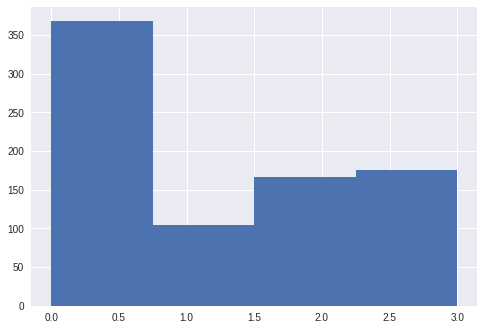

In [0]:
plt.hist(train_labels, bins=4)[0]
# plt.show()

In [0]:
train_labels.shape

(816,)

Majority class is 0
Data Distribution : [368. 105. 167. 176.]
(105, 224, 224, 3)
(167, 224, 224, 3)
(176, 224, 224, 3)


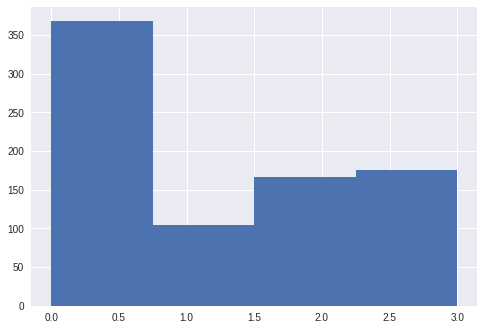

In [0]:
x_train,train_labels = weighted_sampling(data=x_train, labels = train_labels)

In [0]:
x_train.shape

(1472, 224, 224, 3)

In [0]:
y_train = to_categorical(train_labels,num_classes=num_classes)


In [0]:
x_test/=255.0

In [0]:
model = vgg_model(4)

58892288/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
model_file = './weights_messidor_tf.279-1.18.hdf5'

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:

adam_ = keras.optimizers.Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam_,loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
train_size = x_train.shape[0]
val_size = x_val.shape[0]

In [0]:
train_datagen,val_datagen = augment_data()

In [0]:
train_generator = train_datagen.flow(x_train,y_train,batch_size=batch_size)

In [0]:
val_generator = val_datagen.flow(x_val,y_val,batch_size=batch_size)

In [0]:
# test_generator = val_datagen.flow(x_test,y_test,shuffle = False,class_mode='categorical', batch_size=1)

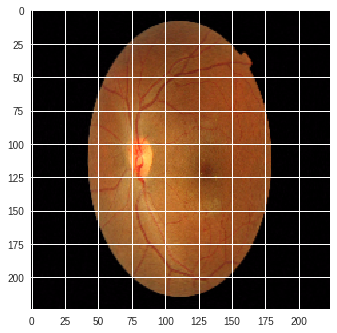

In [0]:
plt.imshow(next(train_generator)[0][0])
plt.show()

In [0]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [0]:
curr_epoc = 300

In [0]:
epochs = 500

In [0]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_size // batch_size,
        epochs=epochs,
        initial_epoch=curr_epoc,
        validation_data=val_generator,
        validation_steps =  val_size // batch_size,
#         class_weight=class_weights,
         verbose=1,
        callbacks = callbacks)

#saves weights just to be safe!
# model.save_weights('weights_1.h5')

# model_json = model.to_json()
# with open("./saved_models/model3_BN.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("./saved_models/model_weights3_BN.h5")
# print("Saved model to drive")

Epoch 301/500
44/44 [==============================] - 39s 894ms/step - loss: 0.9580 - acc: 0.5878 - val_loss: 1.2244 - val_acc: 0.4732

Epoch 00301: val_loss did not improve from 1.18292
Epoch 302/500
44/44 [==============================] - 37s 838ms/step - loss: 0.9929 - acc: 0.5511 - val_loss: 1.2901 - val_acc: 0.4643

Epoch 00302: val_loss did not improve from 1.18292
Epoch 303/500
44/44 [==============================] - 37s 838ms/step - loss: 0.9342 - acc: 0.5965 - val_loss: 1.2421 - val_acc: 0.4821

Epoch 00303: val_loss did not improve from 1.18292
Epoch 304/500
44/44 [==============================] - 37s 838ms/step - loss: 0.9912 - acc: 0.5601 - val_loss: 1.2122 - val_acc: 0.4911

Epoch 00304: val_loss did not improve from 1.18292
Epoch 305/500
44/44 [==============================] - 37s 841ms/step - loss: 0.9543 - acc: 0.5758 - val_loss: 1.2497 - val_acc: 0.4766

Epoch 00305: val_loss did not improve from 1.18292
Epoch 306/500
44/44 [==============================] - 37s 8

In [0]:
np.savez_compressed('./history_{}'.format(model_type), a=history.history)

In [0]:
model.evaluate(x_test,y_test)

240/240 [==============================] - 2s 9ms/step


[1.271661146481832, 0.43333333333333335]

In [0]:
y_pred =   np.argmax(model.predict(x_test),axis=-1)
y_actual = np.argmax(y_test,axis=-1)

In [0]:
cm = confusion_matrix(y_actual,y_pred)
precision_recall_fscore_support(y_actual,y_pred)

(array([0.6       , 0.25      , 0.36842105, 0.41176471]),
 array([0.74358974, 0.05882353, 0.15217391, 0.65116279]),
 array([0.66412214, 0.0952381 , 0.21538462, 0.5045045 ]),
 array([117,  34,  46,  43]))

In [0]:
plot_confusion_matrix(cm,np.arange(4))

array([117.,  34.,  46.,  43.])

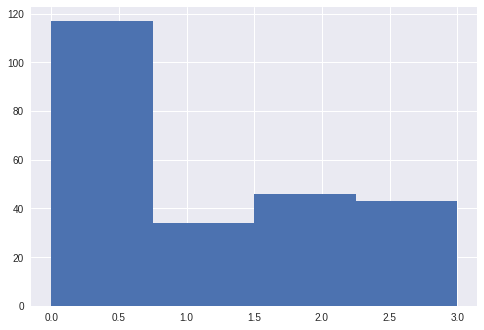

In [0]:
plt.hist(y_actual,bins=num_classes)[0]

array([145.,   8.,  19.,  68.])

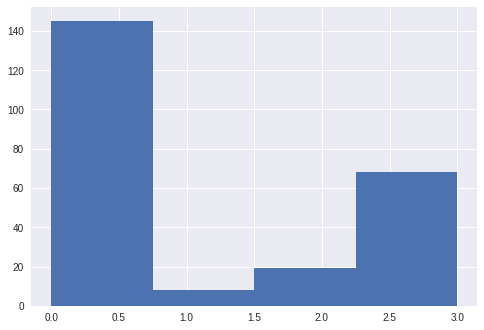

In [0]:
plt.hist(y_pred,bins=num_classes)[0]

In [0]:
# Evaluating the model with best weights obtained during training
def evaluate_model(x_test,y_test,model_file):
  
  model = load_model(model_file)
#   model.load_weights(weight)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  scores = model.evaluate(x_test, y_test, verbose=1)

  
  print("Test Accuracy: %.2f%%" % (scores[1]*100))

In [0]:
evaluate_model(x_test,y_test,model_file)

240/240 [==============================] - 6s 24ms/step
Test Accuracy: 52.50%
